## Marketing Analytics for Mobile Application

Mobile application receives traffic from different sources. This traffic is not homogeneous and we need to know it better in order to optimize marketing activity

We need to analyze dataset in order to find useful insights: what segments of data bring traffic with the best quality (Main metric is conversion rate from lead to client. There can be other metrics as well) 


Questions to consider:
<br>-How users are distributed over countries?
<br>-How many outliers are there in data (in terms of deposits)?
<br>-Find segments with best conversion rate (client/lead ratio) and explain why you consider them best ones
<br>-Visualize deposits distribution over sources and channels
<br>-What are your advices to marketing team in order to optimize their activity?

'data.csv' contains lead/client data, 'country.csv' contains ISO codes for countries

<br>**Data description**: 
<br>*Client_id* - unique id of lead/client. it's assigned during registration and isn't changed anymore 
<br>*Country* - country of lead/client (iso2). It's in the separate file (countries.csv)
<br>*Source* - source of traffic acquisition. There are two possible sources (posts and telegram channel). if Source contains "postid" - it means that lead came from article. id of post doesn't matter. if Source contains "telegram" - it means that lead came from telegram<br>*Channel* - channel of traffic. For example, user can come from 'telegram' source and from 'affiliate' channel
<br>*Clicks* - amount of clicks user made during first day after registration
<br>*Latency* - time of application loading in miliseconds
<br>*Depo* - amount of deposit, USD


Glossary:
Lead: user who registered inside mobile app
Client: user who registered inside mobile app AND made a deposit

In [1]:
# importing libraries, loading datasets
import pandas as pd
import matplotlib.pyplot as plt

countries = pd.read_csv('countries.csv')
data = pd.read_csv('data.csv')

### How users are distributed over countries? 

In [2]:
# remove duplicate client_ids from countries dataset, merge with clients dataset and fill NaNs with 'N/A' values
countries.drop_duplicates(['client_id'], keep='last', inplace=True)
data = pd.merge(data, countries, how='left', on='client_id')
data.fillna('N/A', inplace=True)

# show country distribution in table
t = pd.DataFrame({'country':data.country.value_counts().keys(),
                  'users count':data.country.value_counts(), 
                  '% of total':round(data.country.value_counts(normalize=True)*100,2)})
t = t.reset_index(drop=True)
t

,country,users count,% of total
0,N/A,61754,28.16
1,DE,14504,6.61
2,ES,14443,6.59
3,US,14427,6.58
4,IS,14407,6.57
5,VN,14374,6.55
6,LT,14341,6.54
7,FR,14292,6.52
8,MO,14226,6.49
9,IN,14215,6.48


Out of 219314 users recorded over the period, 61754 users (28% of total) had no information about the country. Other users were almost evenly distributed, with each country attributing to approximately 14k users (about 6.4-6.6% of total for each country)

### How many outliers are there in data (in terms of deposits)?

In [3]:
print('There are ' + str(len(data[data['depo'] == 0])) + ' clients that have not deposited any funds, whereas ' +
      str(len(data[data['depo'] != 0])) + ' had non-zero deposit')

There are 209216 clients that have not deposited any funds, whereas 10098 had non-zero deposit


In [4]:
# descriptive statistics of the deposits data (excluding zero deposits)
deposits = data[data['depo'] != 0]
deposits['depo'].describe()

count    10098.000000
mean       485.653397
std       1792.419644
min       -164.000000
25%        210.000000
50%        319.000000
75%        428.000000
max      31675.000000
Name: depo, dtype: float64

In [5]:
# there are 108 negative deposits that doesn't make sense and can be considered an erroneous data
len(deposits[deposits['depo']<0])

108

Outliers are defined as values that are lower than first quartile - 1.5 * interquartile range or higher than third quartile + 1.5 * interquartile range. Interquartile range = third quartile (Q3) - first quartile (Q1)

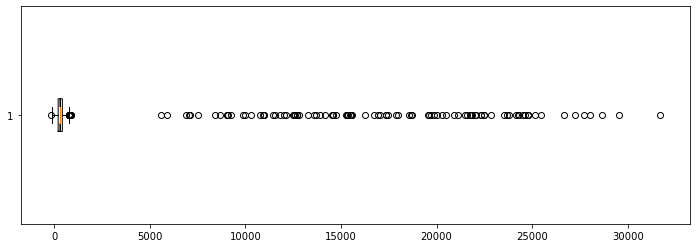

In [6]:
# by looking at the boxplot we can see that most of the outliers are deposits above 5000 USD
fig, ax = plt.subplots(figsize=(12,4))
ax.boxplot(deposits['depo'], notch=True, vert=0)
plt.show()

In [7]:
# labeling outliers and negative deposits
Q1 = deposits['depo'].describe().loc['25%']
Q3 = deposits['depo'].describe().loc['75%']
IQR = Q3 - Q1 

outlier_marker = []
for i in data['depo']:
    if i < 0:
        outlier_marker.append(1)
    elif i > 0 and (i < (Q1-1.5*IQR) or i > (Q3 + 1.5*IQR)):
        outlier_marker.append(1)
    else:
        outlier_marker.append(0)
        
data['outlier'] = outlier_marker

# print the number of outliers
len(data[(data['outlier'] == 1) & (data['depo'] > 0)])

111

There are 10098 clients that actually deposited some funds. Average deposited amount is 485 USD and median is 319 USD. 
There are 108 negative deposits that probably were the result of error, because deposits cannot be negative and 111 outliers (deposit amounts that lie beyond Q1/Q3+-1.5 * IQR range)

Total number of outliers = 108+111 = 219

### Find segments with best conversion rate (client/lead ratio) and explain why you consider them best ones

In [8]:
# remove outliers from the data
data_norm = data[data['outlier'] == 0]
data_norm = data_norm.reset_index()

# transform 'segment' column by removing id numbers from posts
data_norm['segment'] = data_norm['segment'].apply(lambda x: 'post' if 'postid' in x else x)

# look at numbers of leads from all segments and channels
data_norm.groupby(['segment', 'channel'], as_index=False)['client_id'].count().sort_values(by=['segment','client_id'], ascending=False)

,segment,channel,client_id
9,telegram,facebook,20715
10,telegram,smm,18946
11,telegram,social media,12187
8,telegram,direct,6101
7,telegram,affiliate,3050
6,telegram,N/A,610
3,post,facebook,55736
4,post,smm,46777
5,post,social media,30022
2,post,direct,15592


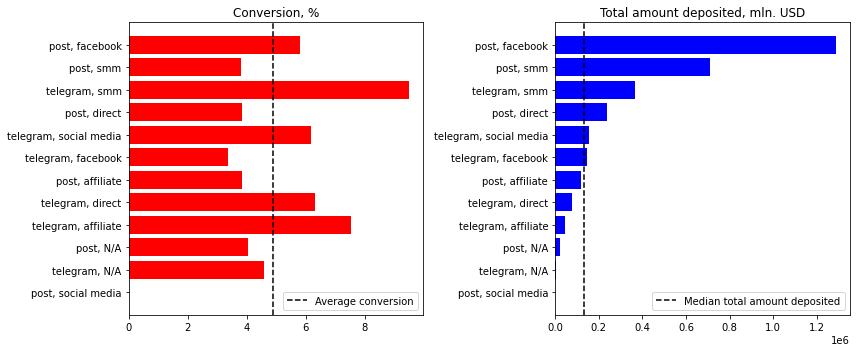

In [9]:
# plot graphs with conversion rates and total deposit amount by segment & channel
d1 = data_norm.groupby(['segment', 'channel'], as_index=False)['depo'].agg(lambda x: round(x[x>0].count()/x.count()*100,2))
d2 = data_norm.groupby(['segment', 'channel'], as_index=False)['depo'].sum()

d1['segment-channel'] = d1['segment'] + ', ' + d1['channel']
d2['segment-channel'] = d1['segment'] + ', ' + d1['channel']

merged = pd.merge(d1, d2[['segment-channel','depo']], how='left', on='segment-channel').sort_values(by=['depo_y'])

fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].barh(merged['segment-channel'], merged['depo_x'], color='red')
ax[1].barh(merged['segment-channel'], merged['depo_y'], color='blue')
ax[0].set_title('Conversion, %')
ax[1].set_title('Total amount deposited, mln. USD')

ax[0].axvline(x = merged['depo_x'].mean(), color = 'black', linestyle='--', label='Average conversion')
ax[1].axvline(x = merged['depo_y'].median(), color = 'black', linestyle='--', label='Median total amount deposited')

ax[0].legend(loc=4)
ax[1].legend(loc=4)

fig.tight_layout()
plt.show()

Telegram attracted traffic with the best conversion rates (SMM, social media, direct and affiliate channels), that were above average (6-8% conversion rates). However traffic from posts (Facebook, SMM, direct) attracted total deposit amounts that were significantly higher than the median across other segments/channels

### Visualize deposits distribution over sources and channels

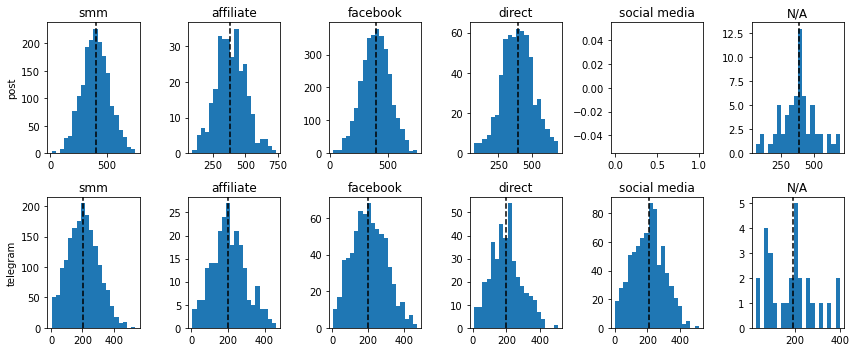

In [10]:
# make multiple histograms with distribution of deposits over sources and channels, add black lines to show median deposit amount
fig, ax = plt.subplots(2, 6, figsize=(12,5))

indx = 0
columns = -1
for seg in data_norm['segment'].unique():
    columns = columns + 1
    indx = 0
    for chan in data_norm['channel'].unique():
        d = data_norm[(data_norm['segment'] == seg) & (data_norm['channel'] == chan) & (data_norm['depo'] > 0)]
        ax[columns][indx].hist(d['depo'],bins=20)
        ax[columns][indx].set_title(chan)
        ax[columns][indx].axvline(x = d['depo'].median(), color = 'black', linestyle='--')
        indx += 1

ax[0][0].set_ylabel(data_norm['segment'].unique()[0])
ax[1][0].set_ylabel(data_norm['segment'].unique()[1]) 
fig.tight_layout()        
plt.show()

Deposit distributions across segments and channels are roughly normal for the most part. Posts clearly have higher median amount deposited across all channels (except for social media) compared to Telegram

### What are your advices to marketing team in order to optimize their activity?

It is important to find optimal mix of marketing channels - those that provide highest conversion and attract largest deposits.

My advice is to put more effort into developing successful channels and cutting those that do not create value. Based on the data I would suggest:
<br>**(1)** Focus on the support of channels that demonstrate high conversion rates and large deposit inflows (Telegram SMM & Posts on Facebook)
<br>**(2)** Exit channels that do not create any value (Posts on social media)
<br>**(3)** Attract more leads into channels that have high conversion rates, but small deposited amounts (direct, affiliate and social media channels on Telegram). Expansion of those channels will provide higher deposit inflows.